<a href="https://colab.research.google.com/github/InsightofSPb/PyTorch_Study/blob/main/GAN/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа (4) по GAN

**Введение**

В этой лабораторной работе мы будем работать с генерирующей состязательной сетью (GAN), которая является мощным инструментом для генерации изображений, текстов и других типов данных. GAN состоят из двух нейронных сетей: генератора и дискриминатора. Генератор пытается создать новые объекты, которые похожи на обучающие примеры, а дискриминатор пытается отличить реальные примеры от фальшивых.

В этой лабораторной работе мы будем работать с набором данных MNIST, который состоит из 6200 ч/б изображений размером 28x28 пикселя. Мы будем использовать генеративную модель для создания изображений, которые похожи на изображения из набора данных MNIST.

Цель работы

Целью данной лабораторной работы является изучение принципов работы генерирующих состязательных сетей (GAN) и применение их для создания изображений.

**Необходимо:**

Загрузить данные набора данных MNIST.

Предобработать данные.

Разбить данные на обучающую и тестовую выборки.

Создать и обучить базовые сети генератора и дискриминатора.

Оценить качество модели и проанализировать результат.

Попробовать улучшить качество модели, экспериментируя с гиперпараметрами и архитектурой модели.

Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import os

Загрузка данных, установка размера батча, начального значения для псевдогенератора, код для диагностики девайса

In [ ]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
path = os.getcwd()

train_data = DataLoader(torchvision.datasets.MNIST(path, train=True, download=True,
                                                   transform=torchvision.transforms.Compose([
                                                       torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize(
                                                           (0.5,), (0.5,))])),
                        batch_size=batch_size, shuffle=True)

print(next(iter(train_data))[0][1].shape)

**Создание дискриминатора**

Теперь мы создадим дискриминатор, который будет принимать на вход изображение и выводить вероятность того, что оно является реальным.\
Дискриминатор состоит из двух больших слоёв, каждый из которых в свою очередь состоит из 2 и 3 линейных соответственно, 2 и 1 дропаута соответственно. В качестве функции активации применяется LeakyRelu, поскольку она позволила лучше обучаться нейронной сети. Выходной функцией активации является сигмоида.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

**Создание генератора**

Теперь мы создадим генератор, который будет принимать на вход случайный шум и генерировать изображения.
Сеть состоит из 4 линейных слоёв, активация с помощью ReLU, на выходе гиперболический тангенс. Размерность латентного слоя составляет 50

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        return x

Задаём объекты наших классов и в качестве оптимизатора используем Adam, а в качестве функции потерь - бинарную кросс энтропию

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


loss_fn = nn.BCELoss()
optimizer_gen = torch.optim.Adam(params=generator.parameters(), lr=0.001)
optimizer_dis = torch.optim.Adam(params=discriminator.parameters(), lr=0.01)

Обучаем и тестируем сеть

In [ ]:
epochs = 200
gen_loss, dis_loss = [], []

for epoch in range(1, epochs + 1):
    for images, _ in train_data:
        batch_size = images.size(0)
        real_images = images.to(device)  # реальные картинки
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Обучаем дискриминатор на реальных картинках
        real_outputs = discriminator(real_images)
        d_loss_real = loss_fn(real_outputs, real_labels)   # считаем функцию потерь


        # Обучаем дискриминатор на фейковых картинках
        noise = torch.randn(batch_size, 50).to(device)  # генерируем шум
        fake_images = generator(noise)  # подаём его на генератор
        fake_outputs = discriminator(fake_images)  # подаём результат дискриминатору
        d_loss_fake = loss_fn(fake_outputs, fake_labels)  # считаем функцию потерь


        # Итоговая функция потерь дискриминатора
        d_loss = d_loss_real + d_loss_fake   # итоговая функция потерь
        optimizer_dis.zero_grad()
        d_loss.backward()
        optimizer_dis.step()

        # Обучаем генератор
        noise = torch.randn(batch_size, 50).to(device)  # шум
        fake_images = generator(noise)  # фейковое изображение
        outputs = discriminator(fake_images)  # на дискриминатор
        g_loss = loss_fn(outputs, real_labels)

        # update Generator
        optimizer_gen.zero_grad()
        g_loss.backward()
        optimizer_gen.step()

    dis_loss.append(d_loss.detach().cpu().numpy())  # добавляем в массив истории обучения
    gen_loss.append(g_loss.detach().cpu().numpy())

    Template = "epoch: {} | generator loss: {:.3f} | discriminator loss: {:.3f}"
    print(Template.format(epoch, g_loss.item(), d_loss.item()))

    if epoch % 20 == 0:
        with torch.no_grad():
            noise = torch.randn(16, 50).to(device)  # каждые 20 эпох генерируем случайные изображения, 16 штук
            fake_images = generator(noise)
            fake_images = fake_images.view(16, 28, 28)

            # Save the fake images
            fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i].cpu().detach().numpy(), cmap='gray')
                ax.axis('off')
            plt.savefig(os.path.join(path, f'{epoch}.png'))  # и сохраняем их
            plt.clf()
            plt.close('all')

**40 эпоха**

---


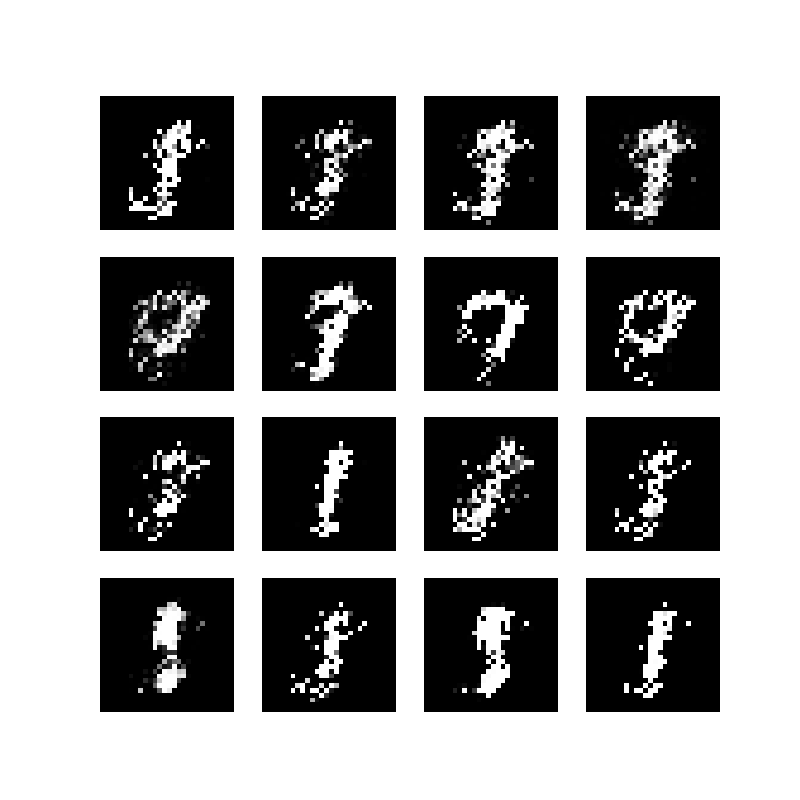

**200 эпоха**


---


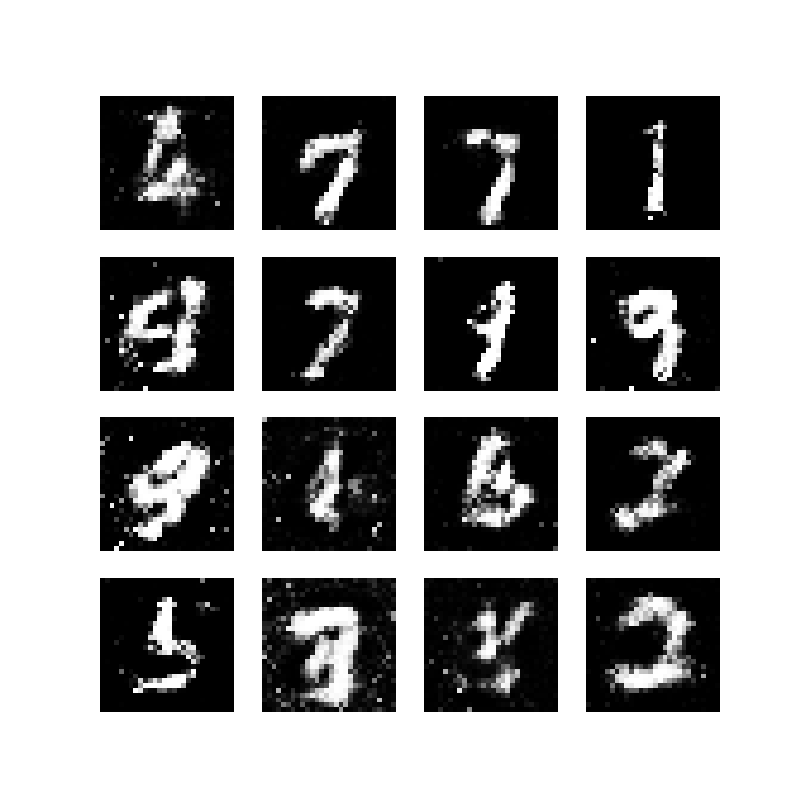

Визуализируем

In [ ]:
def plot_help(epochs, g, d, title):
    plt.rc('lines', linewidth=2.5)
    fig, ax = plt.subplots()
    ax.set_title(title)
    line1, = ax.plot(np.linspace(1, epochs, num=epochs), g, label='gen_loss')
    line1.set_dashes([10, 2, 2, 2])  # 10pt line, 2pt break, 2pt line, 2pt break.
    line1.set_dash_capstyle('round')
    ax.scatter(np.linspace(1, epochs, num=epochs), g)
    line2, = ax.plot(np.linspace(1, epochs, num=epochs), d, label='dis_loss')
    ax.scatter(np.linspace(1, epochs, num=epochs), d)
    ax.legend(handlelength=4)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.savefig(f'{title}.png')
    return fig, ax


title = 'Losses over Epochs'
fig1, ax1 = plot_help(epochs, gen_loss, dis_loss, title)

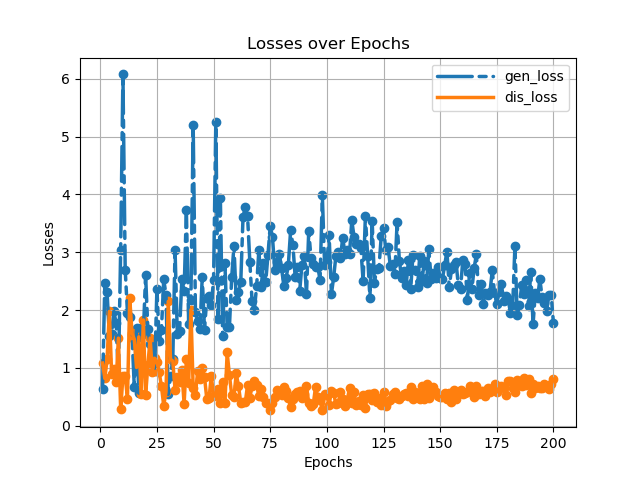

**Выводы:**
В ходе выполнения лабораторной работы были написаны классы для генератора и дискриминатора простой GAN сети. В результате можно наблюдать, что генератор за 200 эпох научился генерировать из шума изображения, отдалённо напоминающие рукописные цифры